***Author: KERROUMI MOHAMED***

**Date : March 2020**


In [1]:
from __future__ import print_function
from __future__ import division
import torch
torch.cuda.current_device()
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm_notebook
import pickle
from lshash import LSHash
from PIL import Image
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage.measure import compare_nrmse
from sklearn.metrics.pairwise import cosine_similarity
import cv2
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

C:\Users\admin\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


**Import the Dataset**

In [2]:

df= pd.read_csv('styles.csv')
df.dropna(inplace = True)
print(df.head())
classes = df['subCategory'].unique()
classes.sort()
dic_classes = {}
for i in range(len(classes)):
    dic_classes[classes[i]] = i
print(dic_classes)
dic ={}
for i in range(len(df)):
    dic[df.iloc[i]['id']+'.jpg'] = dic_classes[df.iloc[i]['subCategory']]


      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
{'Accessories': 0, 'Apparel Set': 1, 'Bags': 2, 'Bath and Body': 3, 'Beauty Accessories': 4, 'Belts': 5, 'Bottomwear': 6, 'Cuffli

In [3]:
classes

array(['Accessories', 'Apparel Set', 'Bags', 'Bath and Body',
       'Beauty Accessories', 'Belts', 'Bottomwear', 'Cufflinks', 'Dress',
       'Eyes', 'Eyewear', 'Flip Flops', 'Fragrance', 'Free Gifts',
       'Gloves', 'Hair', 'Headwear', 'Home Furnishing', 'Innerwear',
       'Jewellery', 'Lips', 'Loungewear and Nightwear', 'Makeup',
       'Mufflers', 'Nails', 'Perfumes', 'Sandal', 'Saree', 'Scarves',
       'Shoe Accessories', 'Shoes', 'Skin', 'Skin Care', 'Socks',
       'Sports Accessories', 'Sports Equipment', 'Stoles', 'Ties',
       'Topwear', 'Umbrellas', 'Vouchers', 'Wallets', 'Watches',
       'Water Bottle', 'Wristbands'], dtype=object)

In [4]:
dic_classes

{'Accessories': 0,
 'Apparel Set': 1,
 'Bags': 2,
 'Bath and Body': 3,
 'Beauty Accessories': 4,
 'Belts': 5,
 'Bottomwear': 6,
 'Cufflinks': 7,
 'Dress': 8,
 'Eyes': 9,
 'Eyewear': 10,
 'Flip Flops': 11,
 'Fragrance': 12,
 'Free Gifts': 13,
 'Gloves': 14,
 'Hair': 15,
 'Headwear': 16,
 'Home Furnishing': 17,
 'Innerwear': 18,
 'Jewellery': 19,
 'Lips': 20,
 'Loungewear and Nightwear': 21,
 'Makeup': 22,
 'Mufflers': 23,
 'Nails': 24,
 'Perfumes': 25,
 'Sandal': 26,
 'Saree': 27,
 'Scarves': 28,
 'Shoe Accessories': 29,
 'Shoes': 30,
 'Skin': 31,
 'Skin Care': 32,
 'Socks': 33,
 'Sports Accessories': 34,
 'Sports Equipment': 35,
 'Stoles': 36,
 'Ties': 37,
 'Topwear': 38,
 'Umbrellas': 39,
 'Vouchers': 40,
 'Wallets': 41,
 'Watches': 42,
 'Water Bottle': 43,
 'Wristbands': 44}

In [5]:
###This two section were run only once
''''import os
for label in classes: 
    os.mkdir('train_images/'+label)'''

"'import os\nfor label in classes: \n    os.mkdir('train_images/'+label)"

In [6]:
'''from tqdm import tqdm_notebook
import shutil
for i in tqdm_notebook(range(len(df))):
    if os.path.exists('images/'+df.iloc[i]['id']+'.jpg'):
        shutil.copy('images/'+df.iloc[i]['id']+'.jpg','train_images/'+df.iloc[i]['subCategory'])'''

"from tqdm import tqdm_notebook\nimport shutil\nfor i in tqdm_notebook(range(len(df))):\n    if os.path.exists('images/'+df.iloc[i]['id']+'.jpg'):\n        shutil.copy('images/'+df.iloc[i]['id']+'.jpg','train_images/'+df.iloc[i]['subCategory'])"

In [7]:
# Number of classes in the dataset
num_classes = len(classes)

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 2 #We already train themodel and saved the best one, so we choose 2 only toshow that the model is learning

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224


    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [10]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [12]:
## Data Processing
transform = transforms.Compose(
    [transforms.Resize((224,224), interpolation=2),  transforms.RandomHorizontalFlip(), transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader =torch.utils.data.DataLoader(torchvision.datasets.ImageFolder('train_images',transform=transform), batch_size=batch_size,
                                          shuffle=True, num_workers=2)





In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in tqdm_notebook(dataloaders): 
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))

        torch.save(model.state_dict(), 'trained_model_bis-epoch{}.pth'.format(epoch))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

In [15]:
####Run this cell only if you want to train the model, otherwise go to the next cell and load
####the saved model
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft= train_model(model_ft, trainloader, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/1
----------



0 Loss: 0.4183 Acc: 0.8993

Epoch 1/1
----------



1 Loss: 0.1758 Acc: 0.9540

Training complete in 54m 52s


**To use the best model I already trained, go to this link and download it,  <br>
https://drive.google.com/drive/folders/1LsIX9vtdZS_QroQcpttf0hdBVwp60xmt?usp=sharing <br>
Put the file in the right directory in order that the following cell works fine.**

In [16]:
model_ft.load_state_dict(torch.load('trained_model-epoch6.pth'))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [17]:
# delete the last fc layer to Exctract feature Maps
modules = list(model_ft.children())[:-1] 
model = nn.Sequential(*modules)
### Now set requires_grad to false
for param in model.parameters():
    param.requires_grad = False
model = model.to(device)
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In the cell below, we save for each image, its corresponding feature Map.

In [18]:
import cv2
import os
import glob
feature_dict = {}
for img_dir in tqdm_notebook([x[0] for x in os.walk('train_images')][1:]):
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    for f1 in tqdm_notebook(files):
        img = cv2.imread(f1)
        img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1).unsqueeze(0).type(torch.FloatTensor)
        img = img.to(device)
        output = model(img).view(512)
        feature_dict[f1] = output.cpu().numpy()

In [19]:
## Exporting as pickle
pickle.dump(feature_dict, open("feature_dict.p", "wb"))

In [20]:
## Loading Feature dictionary
feature_dict = pickle.load(open('feature_dict.p','rb'))

In the cell below, we create a Hash table of Feature Maps using LSH to speed up the search for the nearest neighbor.

In [21]:
## Locality Sensitive Hashing
# params
k = 20 # hash size
L = 10  # number of tables
d = 512 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for img_path, vec in tqdm_notebook(feature_dict.items()):
    lsh.index(vec, extra_data=img_path)


In [22]:
## Exporting as pickle
pickle.dump(lsh, open('lsh.p', "wb"))

In [23]:
feature_dict = pickle.load(open('feature_dict.p','rb'))
lsh = pickle.load(open('lsh.p','rb'))

In [24]:
#This function finds the nearest neighbor of a given image using the Hash table of feature Maps:
def get_similar_item(path, feature_dict, lsh_variable, n_items=5):
    response = lsh_variable.query(feature_dict[path].flatten(), 
                     num_results=n_items+1, distance_func='hamming')
    
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    list_item = list()
    for i in range(1, columns*rows +1):
        if i<n_items+2:
            list_item.append(response[i-1][0][1])
    return(list_item[1:])

<Figure size 432x288 with 0 Axes>

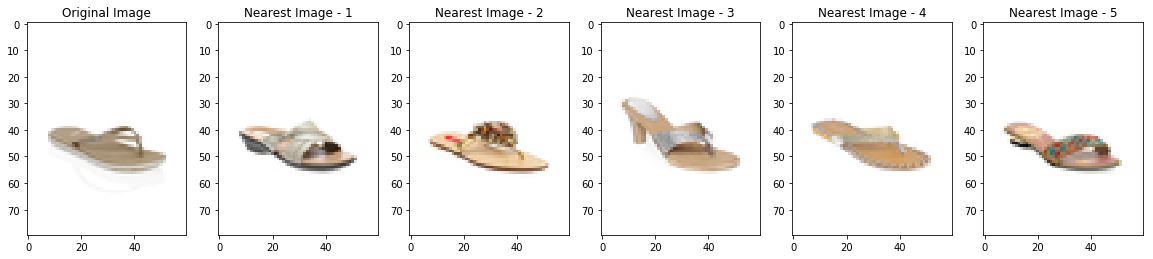

<Figure size 432x288 with 0 Axes>

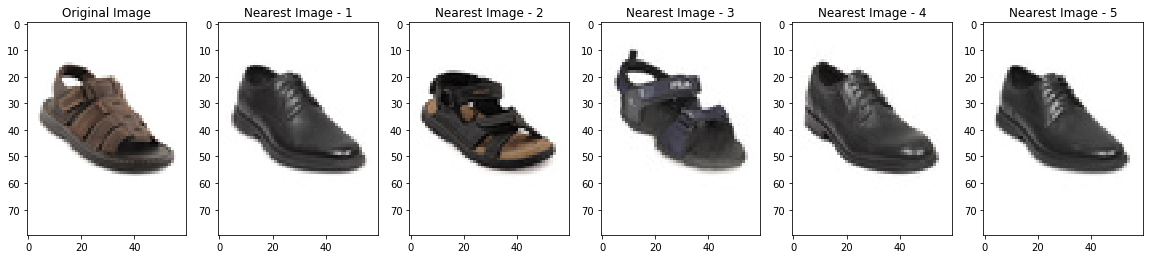

<Figure size 432x288 with 0 Axes>

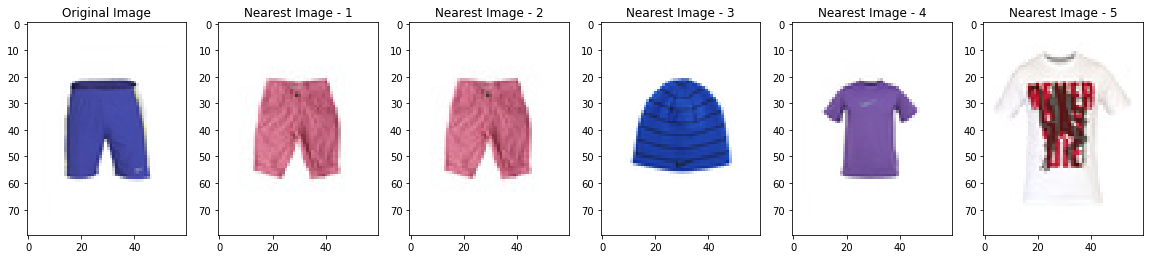

<Figure size 432x288 with 0 Axes>

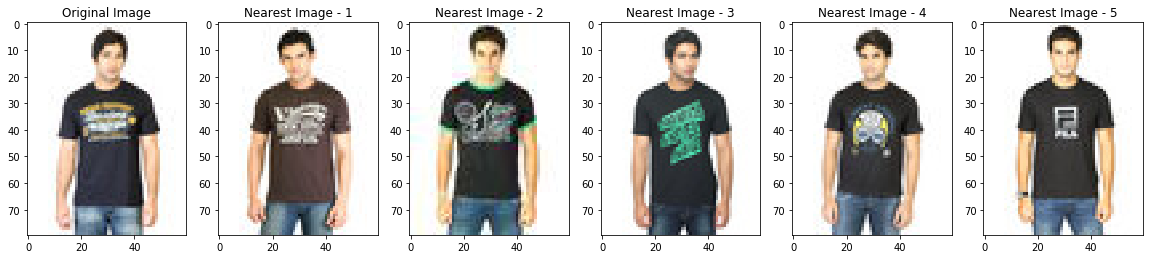

<Figure size 432x288 with 0 Axes>

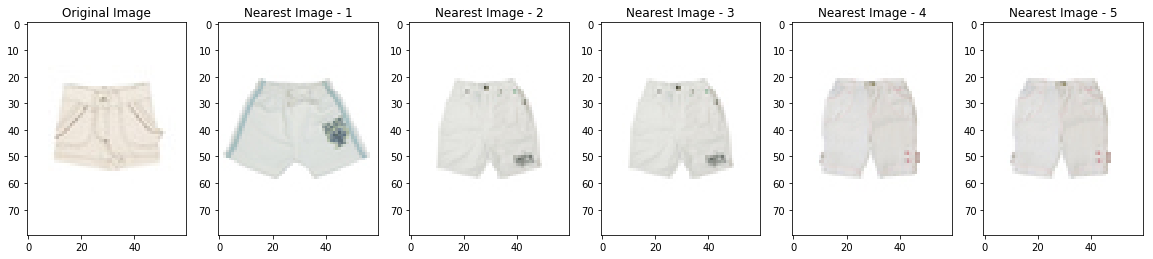

<Figure size 432x288 with 0 Axes>

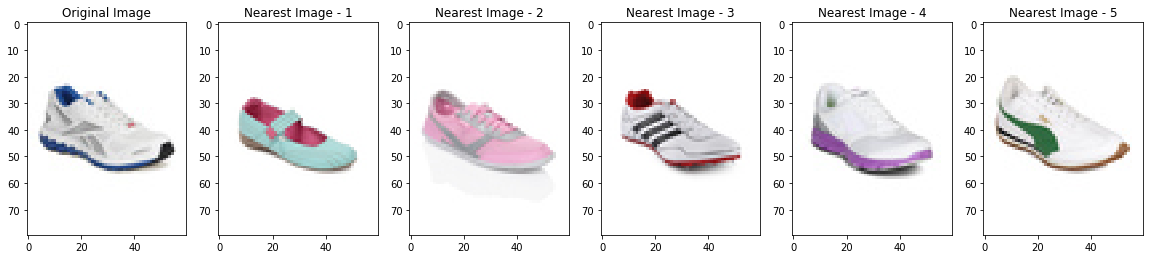

<Figure size 432x288 with 0 Axes>

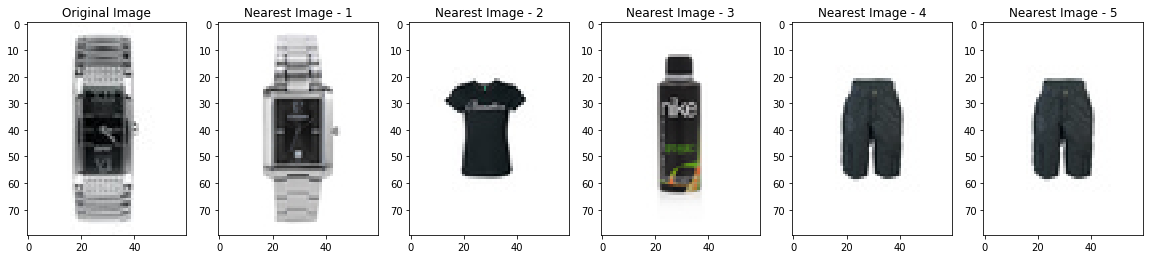

<Figure size 432x288 with 0 Axes>

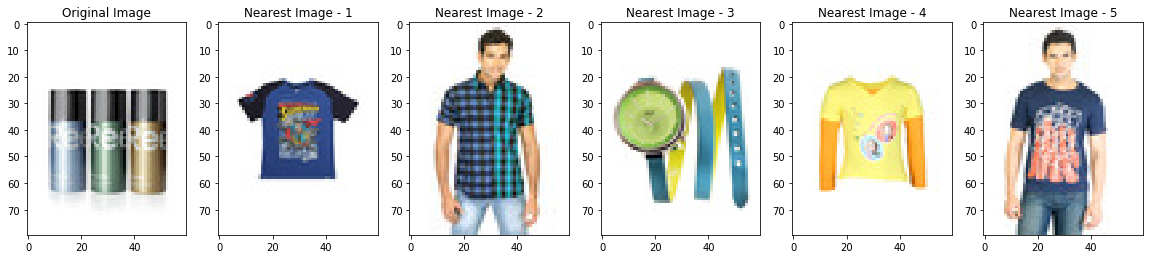

<Figure size 432x288 with 0 Axes>

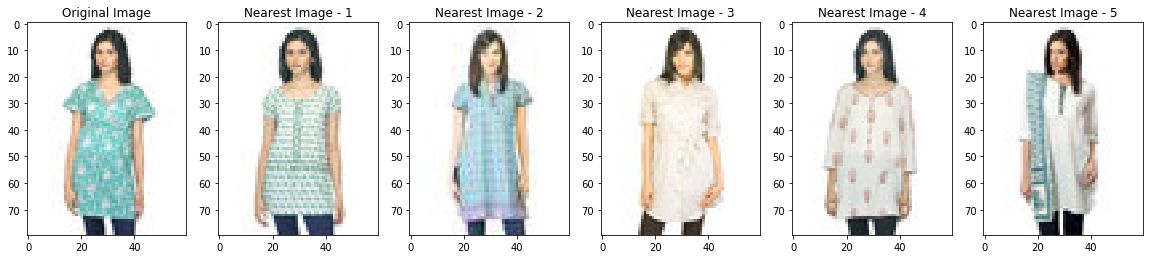

<Figure size 432x288 with 0 Axes>

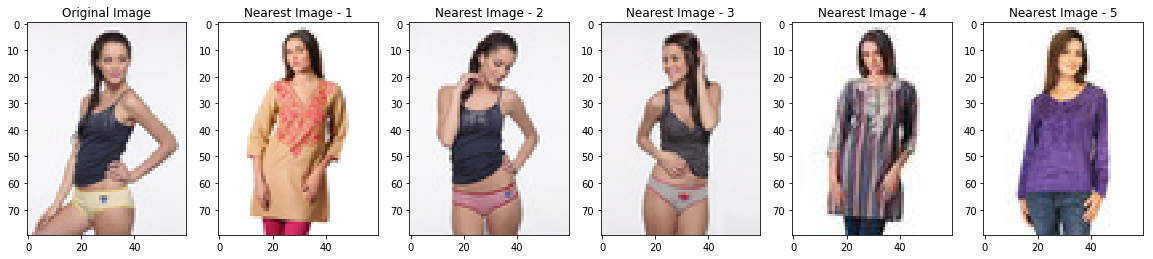


Global Mean Cosine Similarity Image for is : 0.9811960810469575


In [30]:
## Useful functions to find the nearest neignbor and to show the visual matching between images.
def plot_nearest(path_img_1, list_nearest):
    plt.figure()
    plt.figure(figsize= (20,5))
    plt.subplot(1,6,1)
    plt.imshow(Image.open(path_img_1))
    plt.title('Original Image')
    plt.subplot(1,6,2)
    plt.imshow(Image.open(list_nearest[0]))
    plt.title('Nearest Image - 1')
    plt.subplot(1,6,3)
    plt.imshow(Image.open(list_nearest[1]))
    plt.title('Nearest Image - 2')
    plt.subplot(1,6,4)
    plt.imshow(Image.open(list_nearest[2]))
    plt.title('Nearest Image - 3')
    plt.subplot(1,6,5)
    plt.imshow(Image.open(list_nearest[3]))
    plt.title('Nearest Image - 4')
    plt.subplot(1,6,6)
    plt.imshow(Image.open(list_nearest[4]))
    plt.title('Nearest Image - 5')
    plt.show()
def find_img_cosine(path_img_1, path_img_2):
    img1 = cv2.imread(path_img_1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = np.reshape(img1,(len(img1)*len(img1[0]),1))
    img1 = [x[0] for x in img1]
    
    img2 = cv2.imread(path_img_2)
    img2 =  cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    img2 = np.reshape(img2,(len(img2)*len(img2[0]),1))
    img2 = [x[0] for x in img2]
    
    try:
        return [cosine_similarity([img1],[img2])[0][0]]
    except:
        print ("Different Dimensions, return empty array")
        return []
test_data = ['train_images\\Flip Flops\\36134.jpg','train_images\\Sandal\\18401.jpg','train_images\\Bottomwear\\31448.jpg','train_images\\Topwear\\20316.jpg','train_images\\Bottomwear\\16803.jpg','train_images\\Shoes\\43352.jpg','train_images\\Watches\\10702.jpg',
             'train_images\\Fragrance\\43099.jpg','train_images\\Topwear\\30942.jpg','train_images\\Innerwear\\42825.jpg']

test_image_cosine = []
for test in tqdm_notebook(test_data):
    list_nearest = get_similar_item(test, feature_dict, lsh,5)
    plot_nearest(test, list_nearest)
    #test_img = cv2.imread(test)
    local_cos_sim = []
    local_image_cosine = []
    for i in range(5):
        test_image_cosine.append(find_img_cosine(test, list_nearest[i])[0])

print ("Global Mean Cosine Similarity Image for is :", np.mean(test_image_cosine))